<a href="https://colab.research.google.com/github/prachijindal02/United-Airlines-Hackathon/blob/main/United_Airlines_Hackathon_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn


=== FLIGHT DIFFICULTY SCORE ANALYZER ===

✓ Loaded 8,099 rows from `Flight Level Data.csv`
✓ Loaded 687,878 rows from `PNR+Flight+Level+Data.csv`
✓ Loaded 687,245 rows from `Bag+Level+Data.csv`
✓ Loaded 51,698 rows from `PNR Remark Level Data.csv`
✓ Loaded 5,612 rows from `Airports Data.csv`

-- Aggregating PNR/passenger data --
→ Passenger aggregates: 8071 flight keys

-- Aggregating baggage data --
→ Baggage aggregates: 10151 flight keys

-- Aggregating special service remarks --
→ Remarks aggregates: 51698 flight keys

-- Combining datasets --
→ Combined flights: 8099

-- Calculating difficulty scores --
→ Scoring done
   Score range: 9 - 84
   Avg score: 48.0

-- Baggage join check --
Flights with any bag data after join: 8099 / 8099
Flights with checked_bags >0: 7924
Flights with transfer_bags >0: 8093

Charts saved to `flight_analysis_charts.png`
Results saved to `flight_difficulty_scores.csv` (8099 rows)

=== ANALYSIS COMPLETE ===



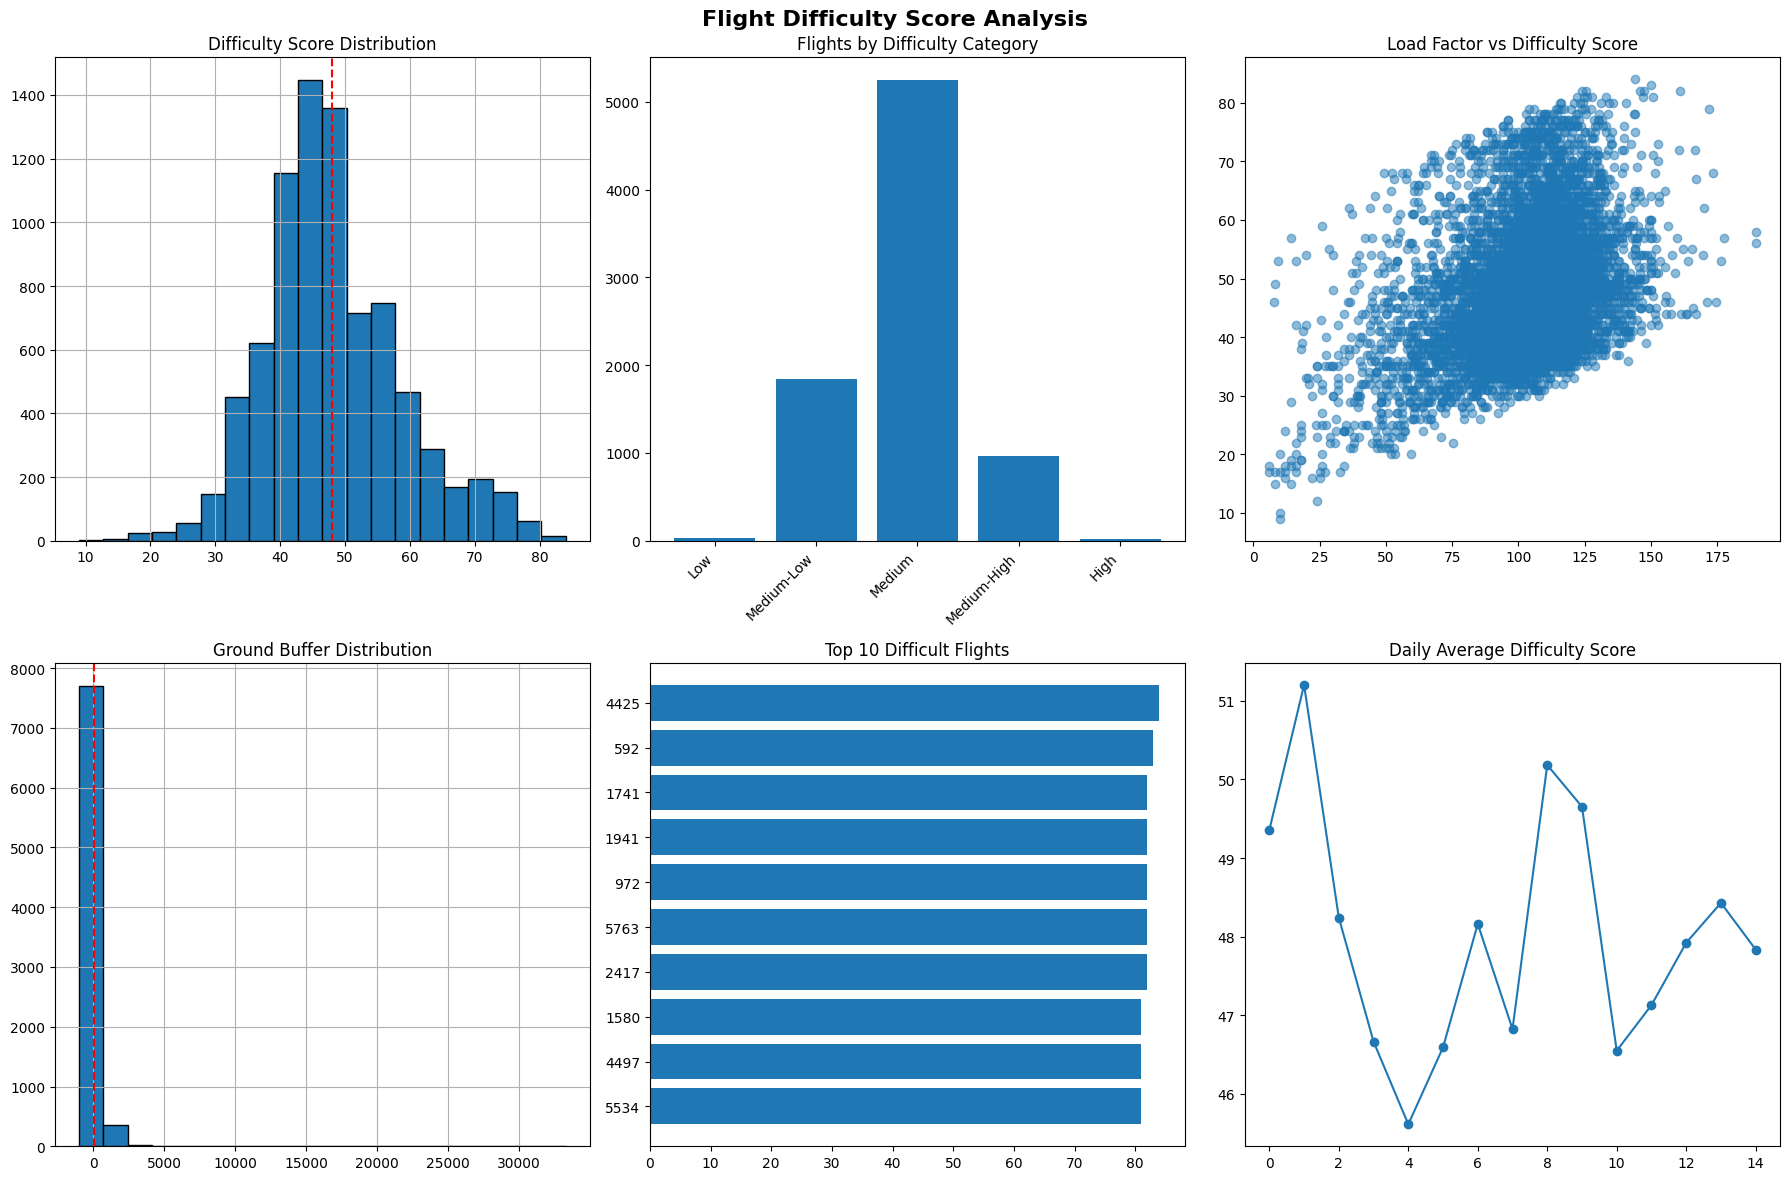

In [2]:
#!/usr/bin/env python3
"""
FLIGHT DIFFICULTY SCORE ANALYZER - FIXED & ROBUST
- Maps Origin -> checked bags
- Includes Hot Transfer handling
- Normalizes flight keys (date-only + trimmed flight numbers)
"""

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# CONFIG
# -------------------------
FLIGHT_FILE = 'Flight Level Data.csv'
PNR_FILE = 'PNR+Flight+Level+Data.csv'    # use this exact name from your file list
BAG_FILE = 'Bag+Level+Data.csv'
REMARKS_FILE = 'PNR Remark Level Data.csv'
AIRPORTS_FILE = 'Airports Data.csv'      # optional

OUTPUT_CSV = 'flight_difficulty_scores.csv'
OUTPUT_PNG = 'flight_analysis_charts.png'

# -------------------------
# SAFE LOAD
# -------------------------
def safe_load(path):
    try:
        df = pd.read_csv(path)
        print(f"✓ Loaded {len(df):,} rows from `{path}`")
        return df
    except FileNotFoundError:
        print(f"⚠ File not found: `{path}` — continuing without it.")
        return pd.DataFrame()
    except Exception as e:
        print(f"⚠ Error loading `{path}`: {e} — continuing without it.")
        return pd.DataFrame()

print("\n=== FLIGHT DIFFICULTY SCORE ANALYZER ===\n")
flight_df = safe_load(FLIGHT_FILE)
pnr_df = safe_load(PNR_FILE)
bag_df = safe_load(BAG_FILE)
remarks_df = safe_load(REMARKS_FILE)
airports_df = safe_load(AIRPORTS_FILE)

if flight_df.empty:
    print("ERROR: Flight Level Data is required. Exiting.")
    sys.exit(1)

# -------------------------
# Normalize keys: trim flight numbers and convert scheduled date to YYYY-MM-DD
# -------------------------
def normalize_for_key(df, flight_col='flight_number', date_col_candidates=None):
    if df.empty:
        return df
    # find a date column candidate if not provided
    if date_col_candidates is None:
        date_col_candidates = ['scheduled_departure_date_local', 'scheduled_departure_datetime_local', 'scheduled_departure_date']
    flight_col_use = flight_col if flight_col in df.columns else None
    if not flight_col_use:
        # try to find a column containing both 'flight' and 'number'
        for c in df.columns:
            if 'flight' in c.lower() and 'number' in c.lower():
                flight_col_use = c
                break
    date_col_use = None
    for c in date_col_candidates:
        if c in df.columns:
            date_col_use = c
            break

    # ensure flight_col_use exists
    if flight_col_use:
        df[flight_col_use] = df[flight_col_use].astype(str).str.strip()
    else:
        df['__flight_tmp'] = df.index.astype(str)
        flight_col_use = '__flight_tmp'

    # parse date to date-only string if possible
    if date_col_use:
        try:
            df[date_col_use] = pd.to_datetime(df[date_col_use], errors='coerce').dt.date.astype(str)
        except Exception:
            df[date_col_use] = df[date_col_use].astype(str).str.strip()
    else:
        df['__date_tmp'] = df.index.astype(str)
        date_col_use = '__date_tmp'

    df['flight_key'] = df[flight_col_use].astype(str) + '_' + df[date_col_use].astype(str)
    return df

flight_df = normalize_for_key(flight_df)
pnr_df = normalize_for_key(pnr_df)
bag_df = normalize_for_key(bag_df)
remarks_df = normalize_for_key(remarks_df)

# -------------------------
# PNR aggregation
# -------------------------
print("\n-- Aggregating PNR/passenger data --")
pnr_agg = pd.DataFrame()
if not pnr_df.empty:
    agg_map = {}
    # common names
    if 'total_pax' in pnr_df.columns: agg_map['total_pax'] = 'sum'
    if 'lap_child_count' in pnr_df.columns: agg_map['lap_child_count'] = 'sum'
    if 'is_child' in pnr_df.columns: agg_map['is_child'] = 'sum'
    if 'is_stroller_user' in pnr_df.columns: agg_map['is_stroller_user'] = 'sum'
    # fallback: pick numeric columns if nothing found
    if not agg_map:
        numeric_cols = pnr_df.select_dtypes(include=[np.number]).columns.tolist()
        for c in numeric_cols[:4]:
            agg_map[c] = 'sum'
    pnr_agg = pnr_df.groupby('flight_key').agg(agg_map)
    rename_map = {}
    if 'total_pax' in pnr_agg.columns: rename_map['total_pax'] = 'passengers'
    if 'lap_child_count' in pnr_agg.columns: rename_map['lap_child_count'] = 'lap_children'
    if 'is_child' in pnr_agg.columns: rename_map['is_child'] = 'children'
    if 'is_stroller_user' in pnr_agg.columns: rename_map['is_stroller_user'] = 'stroller_users'
    pnr_agg = pnr_agg.rename(columns=rename_map)

print(f"→ Passenger aggregates: {len(pnr_agg)} flight keys")

# -------------------------
# BAG aggregation (map Origin -> checked)
# -------------------------
print("\n-- Aggregating baggage data --")
bag_agg = pd.DataFrame()
if not bag_df.empty:
    if 'bag_type' not in bag_df.columns:
        # try to guess
        candidates = [c for c in bag_df.columns if 'bag' in c.lower()]
        if candidates:
            bag_df = bag_df.rename(columns={candidates[0]: 'bag_type'})
        else:
            bag_df['bag_type'] = ''

    bag_df['bag_type_raw'] = bag_df['bag_type'].astype(str).str.strip()
    bag_df['bag_type_norm'] = bag_df['bag_type_raw'].str.lower()

    def map_bag_type(s):
        if pd.isna(s): return 'other'
        s = s.strip()
        if s == 'origin' or s.startswith('origin'):
            return 'checked'
        if s == 'hot transfer' or 'hot transfer' in s:
            return 'hot_transfer'
        if s == 'transfer' or s.startswith('transfer'):
            return 'transfer'
        if 'check' in s:
            return 'checked'
        return 'other'

    bag_df['bag_type_mapped'] = bag_df['bag_type_norm'].apply(map_bag_type)
    bag_counts = bag_df.groupby(['flight_key', 'bag_type_mapped']).size().unstack(fill_value=0)

    bag_counts['checked_bags'] = bag_counts.get('checked', 0)
    bag_counts['hot_transfer_bags'] = bag_counts.get('hot_transfer', 0)
    bag_counts['transfer_bags'] = bag_counts.get('transfer', 0) + bag_counts.get('hot_transfer', 0)

    numeric_cols = bag_counts.select_dtypes(include=[np.number]).columns
    bag_counts['total_bags'] = bag_counts[numeric_cols].sum(axis=1)

    bag_counts.index.name = 'flight_key'
    bag_agg = bag_counts[['checked_bags', 'transfer_bags', 'hot_transfer_bags', 'total_bags']].copy()

print(f"→ Baggage aggregates: {len(bag_agg)} flight keys")

# -------------------------
# REMARKS aggregation (optional)
# -------------------------
print("\n-- Aggregating special service remarks --")
remarks_agg = pd.DataFrame()
if not remarks_df.empty:
    # try use pnr_creation_date or similar
    date_col = None
    for c in ['pnr_creation_date', 'creation_date', 'date']:
        if c in remarks_df.columns:
            date_col = c
            break
    if 'flight_key' not in remarks_df.columns:
        if 'flight_number' in remarks_df.columns and date_col:
            try:
                remarks_df['date_only'] = pd.to_datetime(remarks_df[date_col], errors='coerce').dt.date.astype(str)
                remarks_df['flight_key'] = remarks_df['flight_number'].astype(str).str.strip() + '_' + remarks_df['date_only']
            except Exception:
                remarks_df['flight_key'] = remarks_df.index.astype(str)
        else:
            remarks_df['flight_key'] = remarks_df.index.astype(str)
    remarks_agg = remarks_df.groupby('flight_key').size().to_frame('special_service_requests')

print(f"→ Remarks aggregates: {len(remarks_agg)} flight keys")

# -------------------------
# COMBINE
# -------------------------
print("\n-- Combining datasets --")
result_df = flight_df.set_index('flight_key').copy()
if not pnr_agg.empty: result_df = result_df.join(pnr_agg, how='left')
if not bag_agg.empty: result_df = result_df.join(bag_agg, how='left')
if not remarks_agg.empty: result_df = result_df.join(remarks_agg, how='left')

expected_numeric = ['passengers','lap_children','children','stroller_users',
                    'checked_bags','transfer_bags','hot_transfer_bags','total_bags','special_service_requests']
for col in expected_numeric:
    if col in result_df.columns:
        result_df[col] = result_df[col].fillna(0)
    else:
        result_df[col] = 0

print(f"→ Combined flights: {len(result_df)}")

# -------------------------
# SCORING
# -------------------------
print("\n-- Calculating difficulty scores --")
def calculate_score(row):
    score = 0.0
    weights = {'ground_time':0.25,'baggage':0.20,'passengers':0.20,'special_services':0.15,'delay':0.10,'hot_transfers':0.10}
    try:
        buffer = float(row.get('scheduled_ground_time_minutes',60)) - float(row.get('minimum_turn_minutes',30))
    except Exception:
        buffer = 30.0
    if buffer <= 0:
        score += weights['ground_time']*100
    elif buffer <=10:
        score += weights['ground_time']*80
    elif buffer <=20:
        score += weights['ground_time']*50
    else:
        score += weights['ground_time']*20

    total_bags = float(row.get('total_bags',0) or 0)
    transfer_bags = float(row.get('transfer_bags',0) or 0)
    passengers = max(float(row.get('passengers',1) or 1),1.0)
    if total_bags > 0:
        transfer_ratio = transfer_bags/total_bags if total_bags>0 else 0
        bags_per_pax = total_bags/passengers if passengers>0 else total_bags
        score += weights['baggage'] * (transfer_ratio*60 + min(bags_per_pax*20,40))

    hot_transfer_bags = float(row.get('hot_transfer_bags',0) or 0)
    hot_transfer_est = hot_transfer_bags if hot_transfer_bags>0 else transfer_bags*0.3
    if hot_transfer_est > 0:
        score += weights['hot_transfers'] * min((hot_transfer_est/10)*100,100)

    try:
        capacity = float(row.get('total_seats',180) or 180)
    except Exception:
        capacity = 180.0
    load_factor = passengers / capacity if capacity>0 else 0
    score += weights['passengers'] * load_factor * 100

    try:
        special = float(row.get('special_service_requests',0) or 0)
        children = float(row.get('children',0) or 0)
        lap_children = float(row.get('lap_children',0) or 0)
        strollers = float(row.get('stroller_users',0) or 0)
    except Exception:
        special = children = lap_children = strollers = 0.0
    service_complexity = special + 0.5*(children+lap_children) + strollers
    score += weights['special_services'] * min(service_complexity*3,100)

    try:
        sched = row.get('scheduled_departure_datetime_local')
        act = row.get('actual_departure_datetime_local')
        if pd.notna(sched) and pd.notna(act):
            scheduled = pd.to_datetime(sched)
            actual = pd.to_datetime(act)
            delay_minutes = (actual - scheduled).total_seconds()/60
            if delay_minutes > 0:
                score += weights['delay'] * min((delay_minutes/30)*100,100)
    except Exception:
        pass

    return float(min(round(score),100))

result_df['difficulty_score'] = result_df.apply(calculate_score, axis=1)
result_df['difficulty_category'] = pd.cut(result_df['difficulty_score'], bins=[0,20,40,60,80,100],
                                          labels=['Low','Medium-Low','Medium','Medium-High','High'])
result_df['load_factor'] = ((result_df['passengers'] / result_df.get('total_seats',180)) * 100).round(1)
result_df['ground_buffer'] = result_df.get('scheduled_ground_time_minutes',0) - result_df.get('minimum_turn_minutes',0)

print("→ Scoring done")
print(f"   Score range: {result_df['difficulty_score'].min():.0f} - {result_df['difficulty_score'].max():.0f}")
print(f"   Avg score: {result_df['difficulty_score'].mean():.1f}")

# -------------------------
# Quick checks for baggage join success
# -------------------------
print("\n-- Baggage join check --")
print("Flights with any bag data after join:", (result_df['total_bags']>0).sum(), "/", len(result_df))
print("Flights with checked_bags >0:", (result_df['checked_bags']>0).sum())
print("Flights with transfer_bags >0:", (result_df['transfer_bags']>0).sum())

# -------------------------
# Visualizations (same layout)
# -------------------------
fig, axes = plt.subplots(2,3,figsize=(18,12))
fig.suptitle('Flight Difficulty Score Analysis', fontsize=16, fontweight='bold')

# Score distribution
result_df['difficulty_score'].hist(bins=20, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Difficulty Score Distribution'); axes[0,0].axvline(result_df['difficulty_score'].mean(), color='red', linestyle='--')

# Category distribution
cat_counts = result_df['difficulty_category'].value_counts().sort_index()
axes[0,1].bar(range(len(cat_counts)), cat_counts.values)
axes[0,1].set_xticks(range(len(cat_counts))); axes[0,1].set_xticklabels(cat_counts.index, rotation=45, ha='right')
axes[0,1].set_title('Flights by Difficulty Category')

# Load vs score
axes[0,2].scatter(result_df['load_factor'], result_df['difficulty_score'], alpha=0.5)
axes[0,2].set_title('Load Factor vs Difficulty Score')

# Ground buffer
result_df['ground_buffer'].hist(bins=20, ax=axes[1,0], edgecolor='black')
axes[1,0].axvline(10, color='red', linestyle='--'); axes[1,0].set_title('Ground Buffer Distribution')

# Top 10 difficult flights
top10 = result_df.nlargest(10, 'difficulty_score')
axes[1,1].barh(range(len(top10)), top10['difficulty_score'].values)
axes[1,1].set_yticks(range(len(top10))); axes[1,1].set_yticklabels(top10.get('flight_number', top10.index).values)
axes[1,1].invert_yaxis(); axes[1,1].set_title('Top 10 Difficult Flights')

# Daily avg (if available)
if 'scheduled_departure_date_local' in result_df.columns:
    try:
        daily_avg = result_df.groupby('scheduled_departure_date_local')['difficulty_score'].mean()
        axes[1,2].plot(range(len(daily_avg)), daily_avg.values, marker='o')
        axes[1,2].set_title('Daily Average Difficulty Score')
    except Exception:
        axes[1,2].text(0.5,0.5,'Daily plot unavailable')
else:
    axes[1,2].text(0.5,0.5,'scheduled_departure_date_local missing')

plt.tight_layout()
plt.savefig(OUTPUT_PNG, dpi=300, bbox_inches='tight')
print(f"\nCharts saved to `{OUTPUT_PNG}`")

# -------------------------
# Export results
# -------------------------
export_cols = [
    'flight_number','scheduled_departure_date_local','scheduled_departure_datetime_local',
    'scheduled_departure_station_code','scheduled_arrival_station_code','fleet_type','carrier',
    'difficulty_score','difficulty_category','passengers','total_seats','load_factor',
    'total_bags','checked_bags','transfer_bags','hot_transfer_bags','special_service_requests',
    'scheduled_ground_time_minutes','minimum_turn_minutes','ground_buffer'
]
export_cols = [c for c in export_cols if c in result_df.columns]
export_df = result_df.reset_index()[export_cols]
export_df.to_csv(OUTPUT_CSV, index=False)
print(f"Results saved to `{OUTPUT_CSV}` ({len(export_df)} rows)")

print("\n=== ANALYSIS COMPLETE ===\n")


In [3]:
from google.colab import files

# Download the output files
files.download('flight_difficulty_scores.csv')
files.download('flight_analysis_charts.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>